# Feedforward network (multistep with error estimation)

In [1]:
# Local imports
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

from paths import PATHS
from data.base import make_splits, get_data, single_X_y, unprocess

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten
import tensorflow.keras.backend as K

In [4]:
df = get_data(trend=True, multistep=7)
splits = make_splits(df,
                     norm=True,
                     multistep=7
                    )
X, y = single_X_y(splits)

training_end = splits['val']['X'].index[0][0]  # end of training date
validation_end = splits['test']['X'].index[0][0]  # end of validation date

/home/iheredia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
# Sample weights (recent samples have higher weight)
dates = splits['train']['X'].index.get_level_values(0)
dates = pd.to_datetime(dates)
n = (dates[-1] - dates).days
w = 0.99 ** n  # geometric discount (works better than linear) 

In [6]:
# Formatting for this specific notebook: Transform to arrays of float32
for i in ['train', 'val', 'test']:
    splits[i]['X'] = splits[i]['X'].values.astype(np.float32)
    splits[i]['y'] = splits[i]['y'].values.astype(np.float32)
#     splits[i]['y'] = np.expand_dims(splits[i]['y'], -1) # reshape output to (N, 1)

Add some modified functions

In [7]:
def bayesian_predict(X, samples=10):
    """
    Modified predict function to account for bayesian uncertainty of Dropout
    """
    y = []
    X = np.array(X)
    for _ in range(samples):
        ysample =  np.array(model(X,
                                  training=True))  # activate dropout during inference
        y.append(ysample)
    y = np.array(y)
    return y.mean(axis=0), y.std(axis=0)


def model_summary(model):
    
    print('\n# Metrics')
    metrics = {'mae': {}, 'mape': {}}
    
    for i in ['train', 'val', 'test']:
        x_t = splits[i]['X']
        y_t = splits[i]['y']

        _, y_err = bayesian_predict(x_t)
        y_p = model.predict(x_t)  # normal inference (no dropout)
        
        # We just compare results for t+7 to be able to compare with single step
        y_t = pd.Series(y_t[:,-1])
        y_p = pd.Series(y_p[:,-1])

        mae = np.abs(y_p - y_t)
        mape = np.abs( (y_p - y_t) / y_t)
        mape = mape.replace([np.inf, -np.inf], np.nan)
        
        metrics['mae'][i] = mae.mean()
        metrics['mape'][i] = mape.mean()

        print(f' - {i.capitalize()}')
        print(f'   Mean Absolute Error (in incidence): {mae.mean():.4f}')
        print(f'   Mean Absolute Percentage Error (in incidence): {mape.mean():.4f}')
        
    return metrics


def save_metrics(metrics, modelname):
    for m in metrics.keys():
        b = pd.DataFrame.from_dict(metrics[m], orient='index', columns=[modelname]).T
        a = pd.read_csv(f'single_step/{m}.csv', index_col=0)
        a = pd.concat([a[~a.index.isin(b.index)], b])
        a.to_csv(f'single_step/{m}.csv')

In [8]:
def build_model(layer_num, layer_cells):

    model = Sequential()
    for i in range(layer_num):
        model.add(Dense(layer_cells,
                        activation="relu",
                        kernel_initializer="he_uniform",
                        name=f"dense{i}"))
        model.add(Dropout(0.05))

    model.add(Dense(7,
                    activation="relu",
                    name="output"))
    return model


keras.backend.clear_session()

model = build_model(layer_num=8, layer_cells=500)

model.compile(loss='MeanSquaredError',
              optimizer=keras.optimizers.Adam(amsgrad=True),
              metrics=['MeanAbsoluteError'])

history = model.fit(x=splits['train']['X'],
                    y=splits['train']['y'],
                    validation_data=(splits['val']['X'],
                                     splits['val']['y']),
                    sample_weight=w,
                    batch_size=12000,
                    epochs=80,
                    verbose=0,
                    shuffle=True)

model.evaluate(x=splits['train']['X'],
               y=splits['train']['y'],
               sample_weight=w,
              )

print(f"Trained for {len(history.history['loss'])} epochs")

404/404 [==============================] - 1s 3ms/step - loss: 202.2125 - mean_absolute_error: 11.7209
Trained for 80 epochs



# Metrics
 - Train
   Mean Absolute Error (in incidence): 17.5127
   Mean Absolute Percentage Error (in incidence): 0.6347
 - Val
   Mean Absolute Error (in incidence): 39.0998
   Mean Absolute Percentage Error (in incidence): 0.2273
 - Test
   Mean Absolute Error (in incidence): 17.0825
   Mean Absolute Percentage Error (in incidence): 0.3308


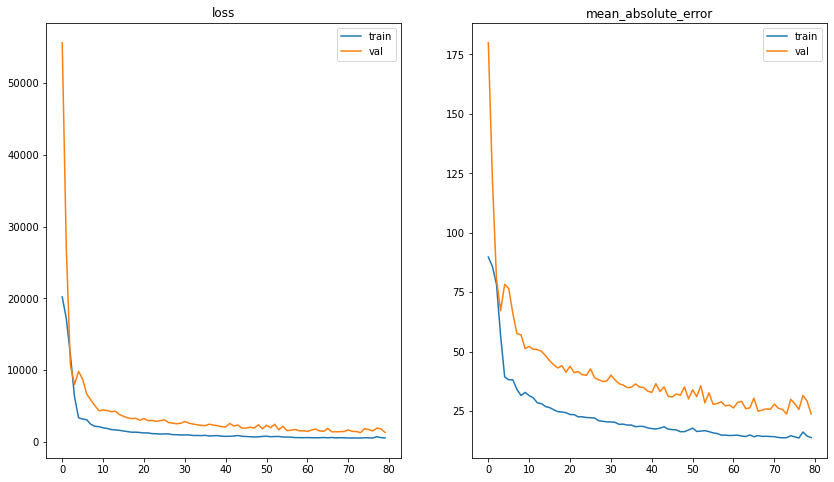

In [9]:
metrics = model_summary(model)

fig, axs = plt.subplots(1,2, figsize=(14,8))
for i, m in enumerate(['loss', 'mean_absolute_error']):
    axs[i].plot(history.history[m], label='train')
    axs[i].plot(history.history[f'val_{m}'], label='val')
    axs[i].set_title(m)
    axs[i].legend()

In [33]:
_, y_err = bayesian_predict(X)
y_pred = model.predict(X)  # normal inference (no dropout)
y_pred = np.round(y_pred).astype(np.int)
true_err = np.array(y) - y_pred
dates = X.index.get_level_values(0)

In [34]:
true_err_df = pd.DataFrame(true_err,
                           columns=[f't+{i+1}' for i in range(true_err.shape[1])],
                           index=X.index)
y_err_df = pd.DataFrame(y_err,
                        columns=[f't+{i+1}' for i in range(y_err.shape[1])],
                        index=X.index)

<AxesSubplot:title={'center':'Distribution of predicted standard deviation for each timestep'}, ylabel='Density'>

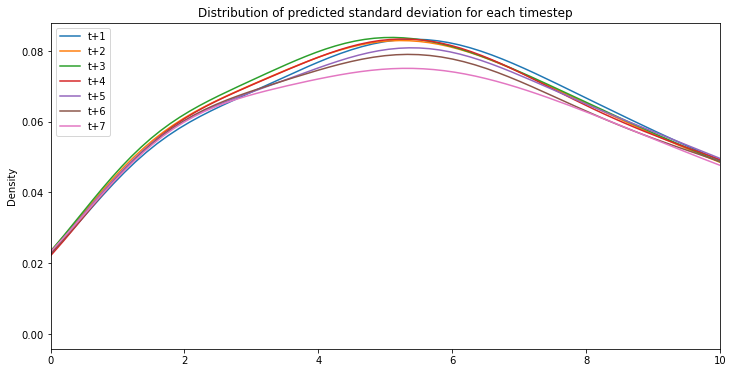

In [35]:
y_err_df.plot.kde(figsize=(12, 6),
                  xlim=(0,10),
                  title= 'Distribution of predicted standard deviation for each timestep')

# plt.figure(figsize=(12,6))
# _ = plt.hist(y_err, range=(0, 10), bins=50)

The original error `y_err` doesn't reflect a particular confidence level. As we can see, the proportion of values that lies inside the $2\sigma$ bound is not the same for each output.

In [36]:
inside = (y_pred - 2*y_err < y) & (y < y_pred + 2*y_err)
inside.mean(axis=0)

incidence 7 (t+1)    0.836338
incidence 7 (t+2)    0.806250
incidence 7 (t+3)    0.755928
incidence 7 (t+4)    0.709374
incidence 7 (t+5)    0.663633
incidence 7 (t+6)    0.621543
incidence 7 (t+7)    0.581483
dtype: float64

So we can rescale the original error to create a new error that reflects a confidence level ($2\sigma$ = 95% confidence). We compute the rescaling factor for the training set, and see how well it holds for the val/test set.

In [37]:
alpha_df = np.abs((y - y_pred) / (2 * y_err))
alpha = alpha_df[dates < training_end].quantile(0.95, axis=0)
new_err = y_err * np.array(alpha)[None, :]
bound = ((y_pred - 2 * new_err) < y) & (y < (y_pred + 2 * new_err))
print('2 sigma confidence bound for training set')
print(bound[dates < training_end].mean(axis=0))
print('2 sigma confidence bound for val/test set')
print(bound[dates >= training_end].mean(axis=0))

bound = ((y_pred - new_err) < y) & (y < (y_pred + new_err))
print('1 sigma confidence bound for training set')
print(bound[dates < training_end].mean(axis=0))
print('1 sigma confidence bound for val/test set')
print(bound[dates >= training_end].mean(axis=0))

2 sigma confidence bound for training set
incidence 7 (t+1)    0.949942
incidence 7 (t+2)    0.949942
incidence 7 (t+3)    0.949942
incidence 7 (t+4)    0.949942
incidence 7 (t+5)    0.949942
incidence 7 (t+6)    0.949942
incidence 7 (t+7)    0.949942
dtype: float64
2 sigma confidence bound for val/test set
incidence 7 (t+1)    0.956984
incidence 7 (t+2)    0.940796
incidence 7 (t+3)    0.936401
incidence 7 (t+4)    0.928076
incidence 7 (t+5)    0.918131
incidence 7 (t+6)    0.912350
incidence 7 (t+7)    0.914200
dtype: float64
1 sigma confidence bound for training set
incidence 7 (t+1)    0.752959
incidence 7 (t+2)    0.746151
incidence 7 (t+3)    0.750406
incidence 7 (t+4)    0.753424
incidence 7 (t+5)    0.760619
incidence 7 (t+6)    0.763017
incidence 7 (t+7)    0.775397
dtype: float64
1 sigma confidence bound for val/test set
incidence 7 (t+1)    0.773589
incidence 7 (t+2)    0.740749
incidence 7 (t+3)    0.708603
incidence 7 (t+4)    0.695190
incidence 7 (t+5)    0.688252
inciden

The rescaling factor seems to work pretty well outside the training set, though it degrades the larger the timestep (probably due to higher variance). We can plot now the distribution of this rescaled std and we now have the nice property that errors increase with the timestep (harder to predict t+7 than t+1). This property wasn't there in the raw predicted error.

<AxesSubplot:title={'center':'Distribution of predicted (rescaled) standard deviation for each timestep'}, ylabel='Density'>

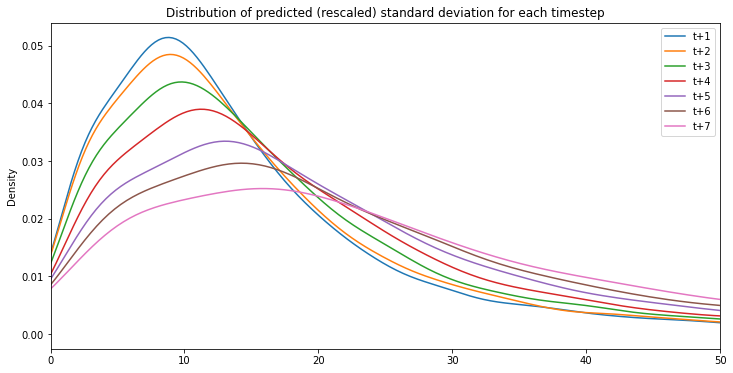

In [38]:
new_err_df = pd.DataFrame(new_err,
                          columns=[f't+{i+1}' for i in range(new_err.shape[1])],
                          index=X.index)
new_err_df.plot.kde(figsize=(12, 6),
                    xlim=(0,50),
                    title= 'Distribution of predicted (rescaled) standard deviation for each timestep')

We can now see how the real error is distributed. For some reason the error is not really symmetrical around x=0. This is partly due to having a RELU activation (which is asymmetrical) in the last layer, but it is not the only factor. This remains to be investigated.

<AxesSubplot:title={'center':'Distribution of true error for each timestep'}, ylabel='Density'>

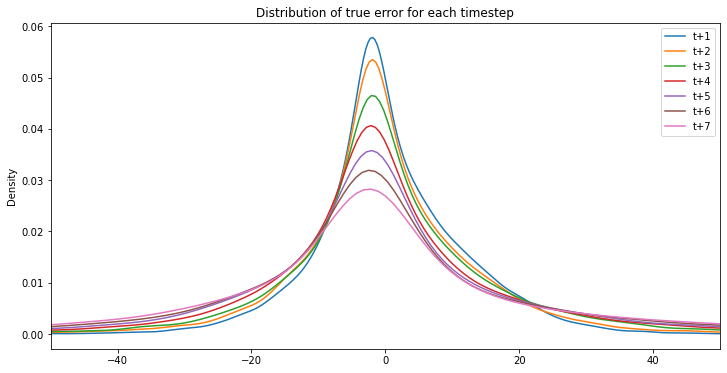

In [39]:
true_err_df.plot.kde(figsize=(12, 6),
                     xlim=(-50,50), title='Distribution of true error for each timestep')

But all of this is useless if the predicted standard deviation doesn't correlated well with the actual true error of the prediction. As we can see the correlation is not perfect but it is definitely not random.

Person correlation: 0.51304154988267
Spearman correlation: 0.4462098130230376


Text(0, 0.5, 'Predited standard deviation')

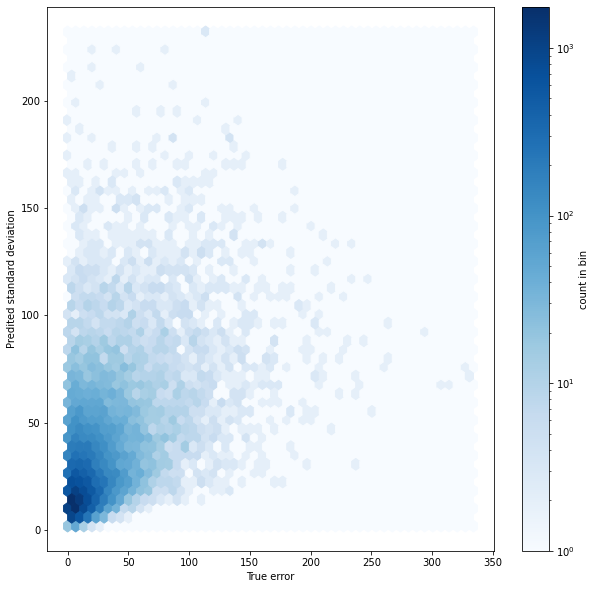

In [40]:
idxs = dates > training_end
x_tmp = np.abs(true_err)[idxs].flatten()
y_tmp = new_err[idxs].flatten()

# x_tmp = np.abs(true_err)[:, 0]
# y_tmp = np.abs(y_err)[:, 0]

from scipy.stats import pearsonr, spearmanr
print(f'Person correlation: {pearsonr(x_tmp, y_tmp)[0]}')
print(f'Spearman correlation: {spearmanr(x_tmp, y_tmp)[0]}')

plt.figure(figsize=(10,10))
plt.hexbin(x_tmp,
           y_tmp,
           gridsize=50,
#            extent=(0,50,0,50),
           bins='log',
           cmap='Blues')
cb = plt.colorbar(label='count in bin')
plt.xlabel('True error')
plt.ylabel('Predited standard deviation')

In [59]:
# y_pred = np.round(y_pred).astype(np.int)
# new_err = np.ceil(new_err).astype(np.int)

# A = pd.DataFrame(y_pred, index=y.index, columns=[f't+{i+1}' for i in range(len(y.columns))])
# B = pd.DataFrame(new_err, index=y.index, columns=[f't+{i+1}' for i in range(len(y.columns))])

# A.columns = pd.MultiIndex.from_product([['mean'], A.columns])
# B.columns = pd.MultiIndex.from_product([['std'], B.columns])

# dfp = pd.concat([A, B], axis=1)
# dfp.to_csv("multi_step/pred_ff_multistep.csv")